In [1]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.plan_a.transformer import MarketSampleTransformer, MarketSampleDataset
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

from matplotlib import pyplot
import json

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:

with open(r"..\forecast\plan_a\data\market_simulator_5.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_6.json", "r") as f:
    test_data = json.loads(f.read())

In [3]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [24]:
print(train_data[:10].tolist())

[[4.952430403757294, 3.932228028891235, 2.660454536516147, 10.14645089481867, 28.482237875563712, 31.8661809233361, 35.06362352248146, 46.184479317066625, -11.267884787029244, 0.9165033975304021, 4.397685592978052, 7.590465615932715, 20.480559678513327, -14.222598166332991, 0.8789472896259339, 4.518783165844632, 8.758114598100262, 23.240649571384246, -24.541023615679713, -16.066593364204333, -9.764333025738148, -4.541107178899347, -0.48859850948282957, 1.6256593475208685, 6.409112532657155, 12.033187520454021, 20.136054097545742, 0.0], [3.2139536913855786, 3.1106555689760915, 1.8205320271462693, -1.8418000739916727, 24.25204932141543, 32.683048107297864, 37.01814202312118, 50.807459698369556, -12.878999926115267, 0.3357429810046782, 3.5269989438575347, 8.74459131649545, 23.011983629777628, -3.792071785081487, 4.899153584393898, 7.159139199647409, 9.473199205378473, 17.385551423139564, -29.19855879021391, -20.723322034801473, -14.824999102151429, -8.934770060772099, -2.7245751799559628,

In [5]:
market_len = 1
# l = 3 * market_len + market_len
l = market_len * 3 + market_len * (5-0) * 3 + 9
def zscore_p(x):
    x = numpy.asarray(x)
    m = numpy.mean(x, axis=0)
    s = numpy.std(x, ddof=1, axis=0)
    return m,s

def zscore(x, m, s):
    x = numpy.asarray(x)
    m = numpy.asarray(m)
    s = numpy.asarray(s)
    # return numpy.column_stack((
    #         (x[:,:l]-m[:l]) / s[:l], x[:,l]
    # ))
    return (x-m) / s

def minmax_p(x):
    x = numpy.asarray(x)
    mmax = numpy.max(x, axis=0)
    mmin = numpy.min(x, axis=0)
    return mmin, mmax

def minmax(x, mmin, mmax):
    x = numpy.asarray(x)
    mmin = numpy.asarray(mmin)
    mmax = numpy.asarray(mmax)
    return (x-mmin) / (mmax-mmin)
    # return numpy.column_stack((
    #         (x[:,:l]-mmin[:l]) / (mmax[:l]-mmin[:l]), x[:,l]
    # ))
    
print(l)
    

27


In [6]:
m,s= zscore_p(train_data)
zscored_t = zscore(train_data, m, s)
zscored_x = zscore(test_data, m, s)

mmin,mmax = minmax_p(train_data)
minmaxed_t = minmax(train_data, mmin, mmax)
minmaxed_x = minmax(test_data, mmin, mmax)

print(zscored_t.shape)

(3000, 28)


In [7]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
p = MLPRegressor(
    hidden_layer_sizes=[50] * 4,
    activation="relu",
    solver="lbfgs",
    # alpha=1e-3,
    # learning_rate_init=1e-3
)
# p = RandomForestRegressor(
#     # alpha=0.999
# )
# p = SVR(
#     # alpha=1
# )
p.fit(
    zscored_t[:,:l],
    zscored_t[:,l]
)

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=[50, 50, 50, 50], solver='lbfgs')

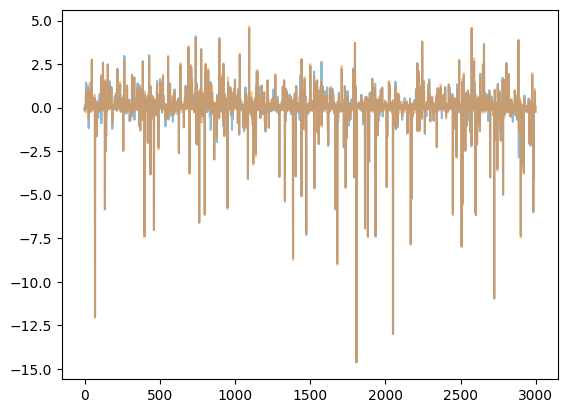

In [8]:

pyplot.plot(zscored_t[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_t[:,:l]), alpha=0.5)

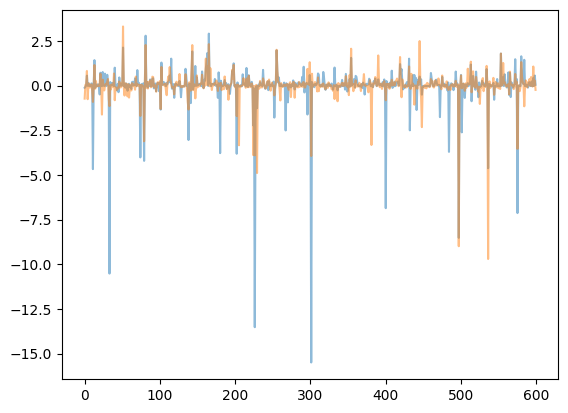

In [9]:

pyplot.plot(zscored_x[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_x[:,:l]), alpha=0.5)

In [10]:
p.score(zscored_x[:,:l], zscored_x[:,l])

0.3924618735514602

In [11]:
p.score(zscored_t[:,:l], zscored_t[:,l])

0.981414184731259

In [12]:
numpy.corrcoef(p.predict(zscored_x[:,:l]), zscored_x[:,l])

array([[1.        , 0.62782516],
       [0.62782516, 1.        ]])

In [13]:
model = MarketSampleTransformer(l, 64, 4, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
batch_size = 600
epoch_size = 200

zscored_t_dataset = MarketSampleDataset(zscored_t)
train_loader = DataLoader(zscored_t_dataset, batch_size=batch_size, shuffle=True)

zscored_x_dataset = MarketSampleDataset(zscored_x)
test_loader = DataLoader(zscored_x_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epoch_size):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        # batch_x, batch_y = batch_x, batch_y
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            # batch_x, batch_y = batch_x, batch_y
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            test_loss += loss.item() * batch_x.size(0)
    avg_test_loss = test_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{epoch_size} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

Epoch 1/200 | Train Loss: 2.161061 | Test Loss: 2.000556
Epoch 2/200 | Train Loss: 1.084113 | Test Loss: 1.697919
Epoch 3/200 | Train Loss: 1.001072 | Test Loss: 1.628711
Epoch 4/200 | Train Loss: 0.973059 | Test Loss: 1.515044
Epoch 5/200 | Train Loss: 0.891509 | Test Loss: 1.458602
Epoch 6/200 | Train Loss: 0.840995 | Test Loss: 1.408949
Epoch 7/200 | Train Loss: 0.798401 | Test Loss: 1.397867
Epoch 8/200 | Train Loss: 0.768120 | Test Loss: 1.300080
Epoch 9/200 | Train Loss: 0.713233 | Test Loss: 1.253358
Epoch 10/200 | Train Loss: 0.659483 | Test Loss: 1.181001
Epoch 11/200 | Train Loss: 0.592299 | Test Loss: 1.119124
Epoch 12/200 | Train Loss: 0.558184 | Test Loss: 1.067145
Epoch 13/200 | Train Loss: 0.509741 | Test Loss: 1.026760
Epoch 14/200 | Train Loss: 0.477860 | Test Loss: 1.037546
Epoch 15/200 | Train Loss: 0.456609 | Test Loss: 1.109004
Epoch 16/200 | Train Loss: 0.443578 | Test Loss: 1.097545
Epoch 17/200 | Train Loss: 0.412126 | Test Loss: 1.051207
Epoch 18/200 | Train Lo

In [15]:
model.eval()
all_preds = []
all_targets = []
# 拿一批数据来预测
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        all_preds.append(preds)    # 收集预测结果
        all_targets.append(batch_y)  # 收集真实标签
        
all_preds = torch.cat(all_preds, dim=0).numpy()     # (400,)
all_targets = torch.cat(all_targets, dim=0).numpy() # (400,)

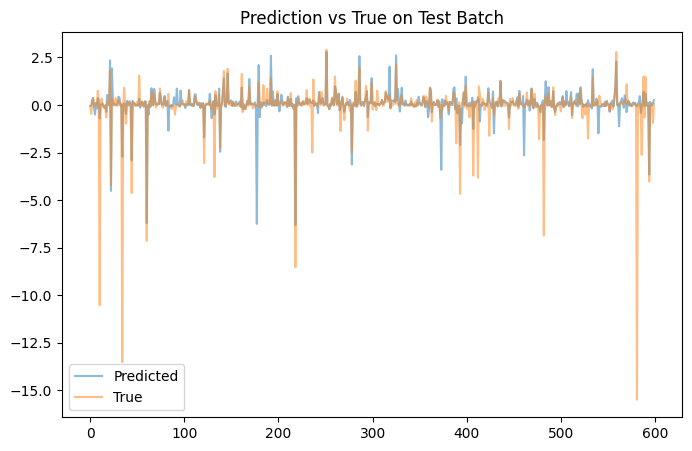

In [21]:
pyplot.figure(figsize=(8,5))
pyplot.plot(all_preds, label="Predicted", alpha=0.5)
pyplot.plot(all_targets, label="True", alpha=0.5)
pyplot.legend()
pyplot.title("Prediction vs True on Test Batch")
pyplot.show()

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_absolute_error(all_targets, all_preds)
print(f"Test MSE on 600 samples: {mse:.6f}")

Test MSE on 600 samples: 0.317055


In [18]:
from sklearn.metrics import r2_score
r2 = r2_score(all_targets, all_preds)
print(f"Test R^2 on 600 samples: {r2:.6f}")

Test R^2 on 600 samples: 0.312957
